# Localize the drone

### Task description

Your task is to figure out the path for a drone.
Drone is moving through Center of Helsinki and it has two sensors attached to it.
This time we are moving street level and we know that the drone is not flying over buildings or passing any objects.

Drone is logging the sensor data into **JSON lines** formatted file for regular intervals. Each of the line represents single **frame** or timestep.

**Using the logged data (measurements) and occupancy map of Helsinki find the path and end position of the drone.**

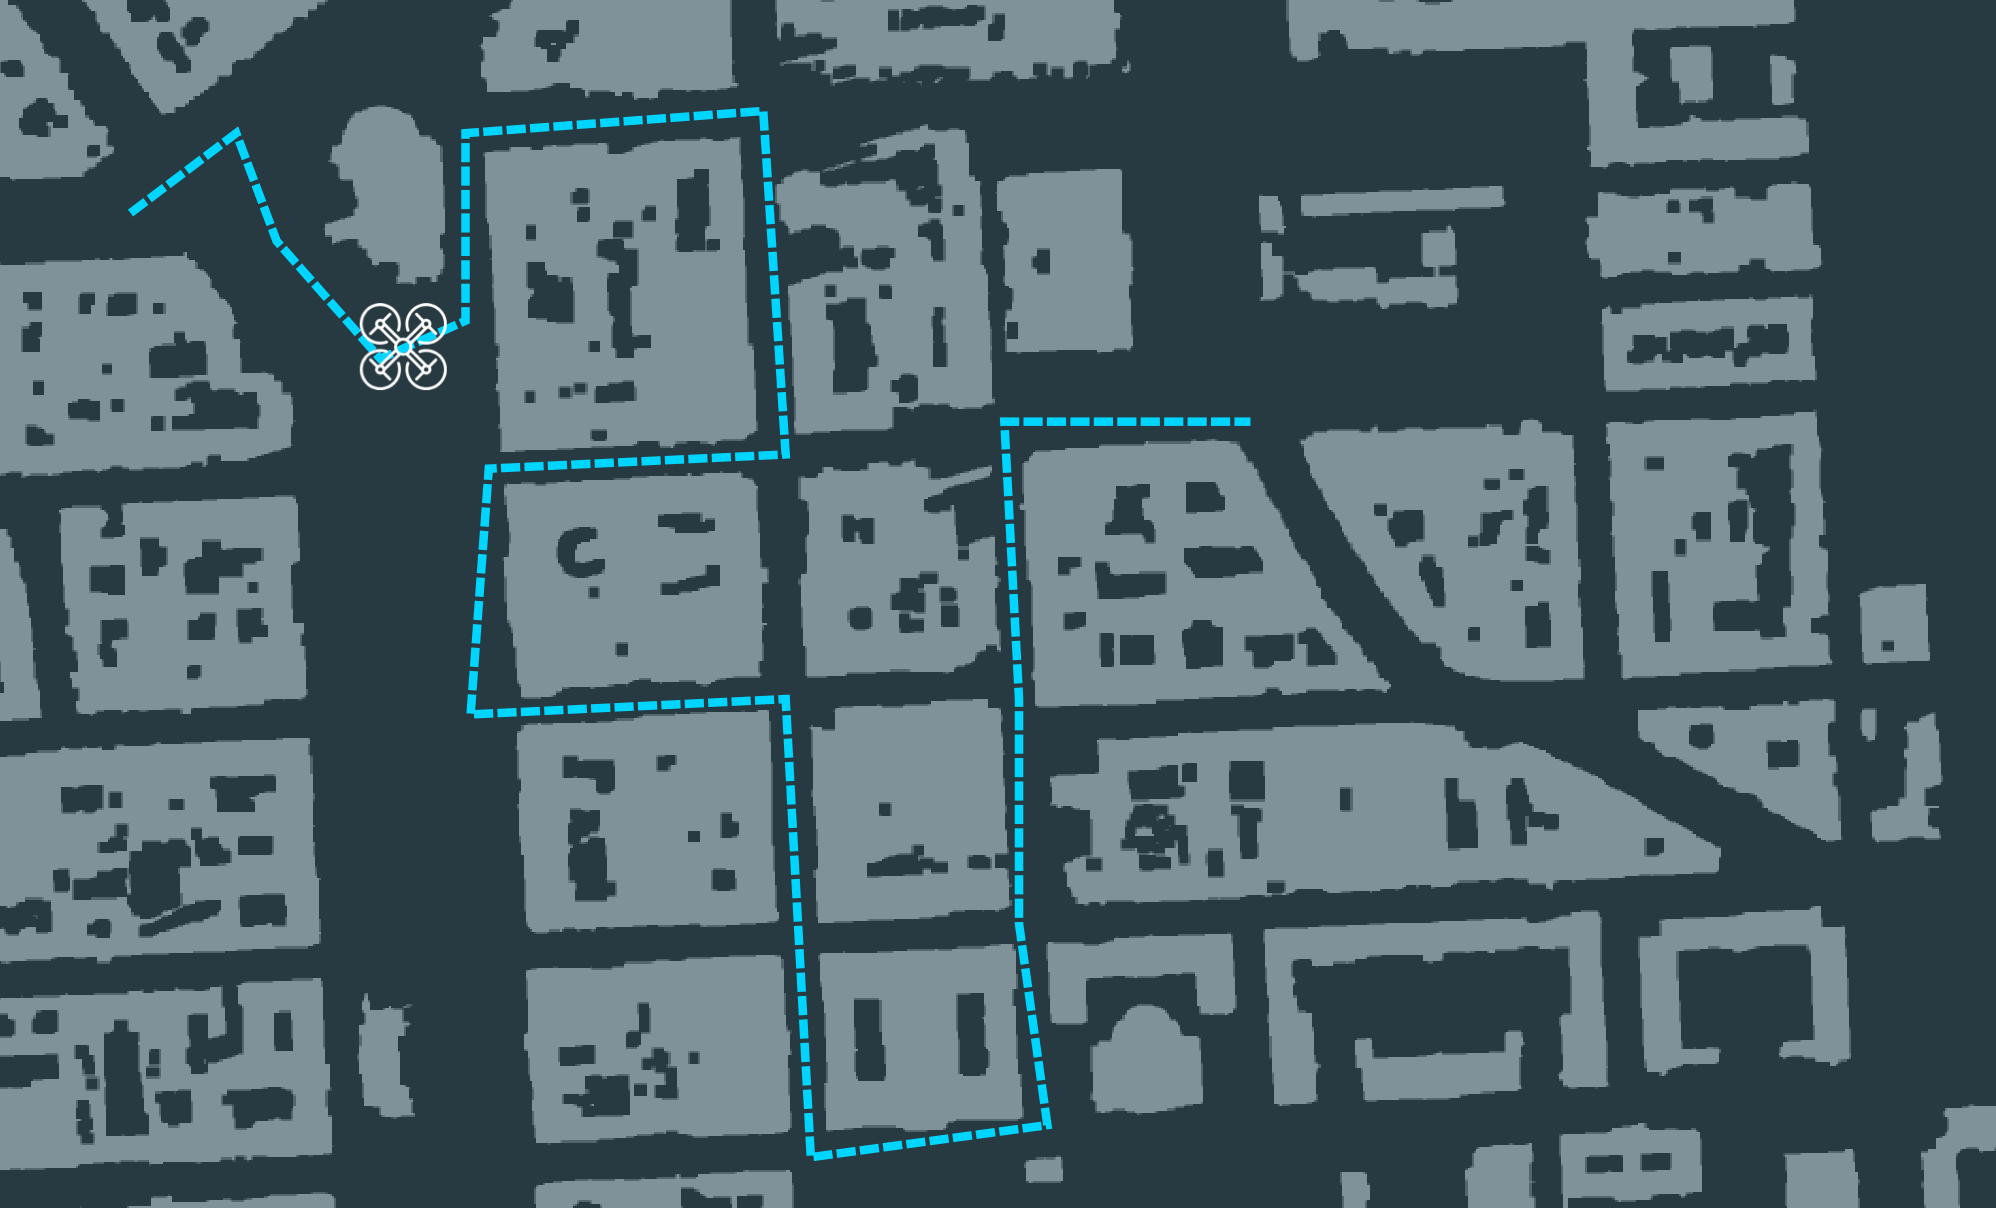


### Map

We have done research already in Helsinki and produced accurate occupancy map of the center area.

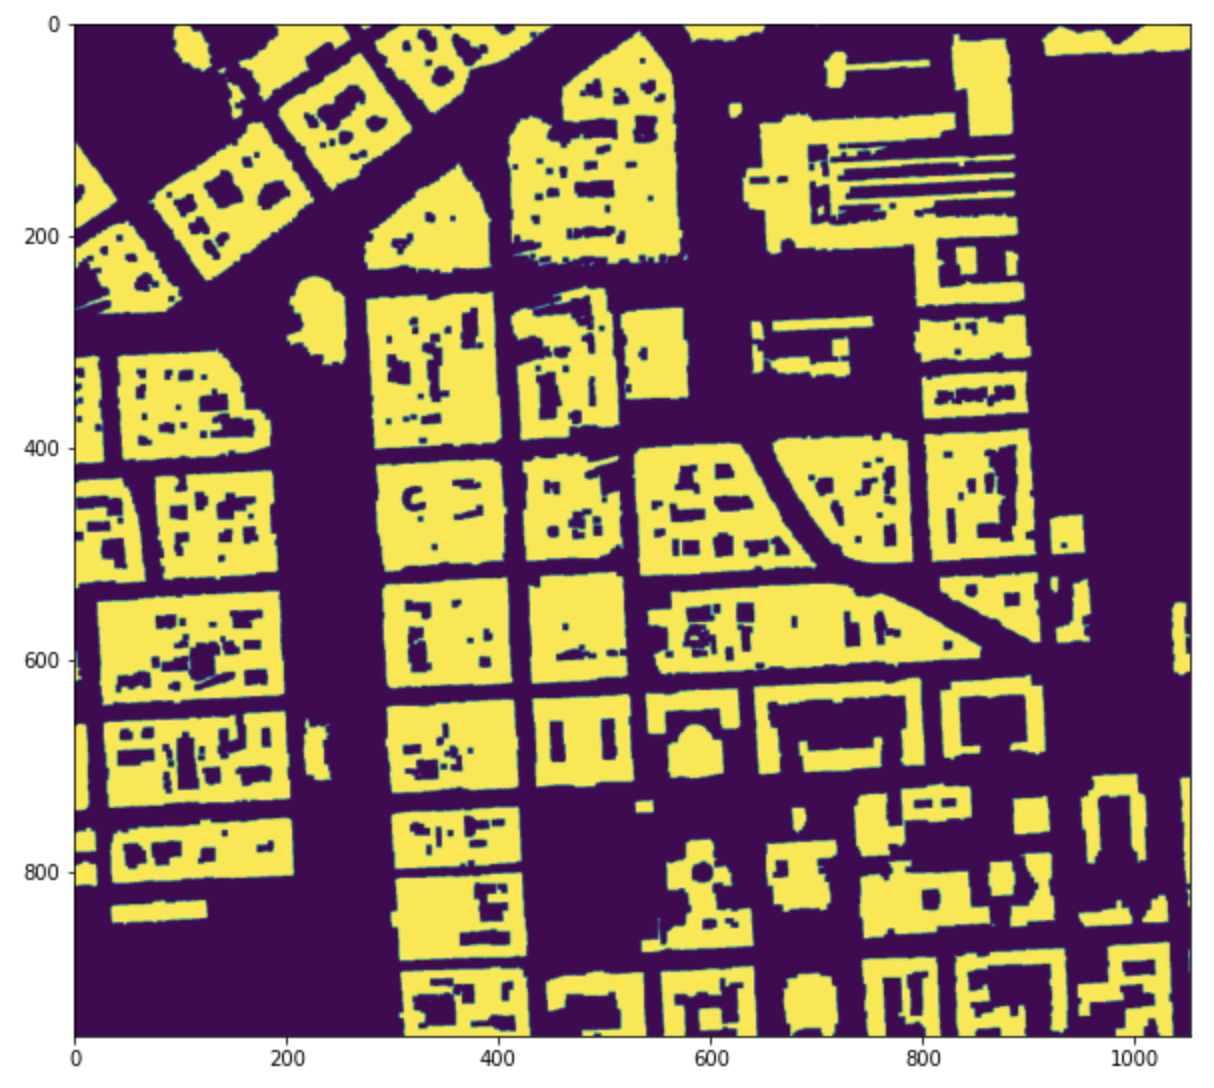

Map size is **1053x955 pixels**.
In the map black areas (pixel value = 0) corresponds areas that are free for movement (roads, parks, squares etc.)
And white areas (pixel value = 255 or 1) corresponds areas blocked by some object. (buildings, walls, gates)

Map is offered in two formats **PNG** and **TXT**.   

**TXT** formatted map has 955 rows each having 1053 values (either 1 or 0)


### Odometry and movements

Drone has odometry sensors that gives you drones relative movement from previous position to current.
There is problem though that sensor is little bit unreliable and there is some amount of noise in the readings.

Following image describes how the odometry sensor works:

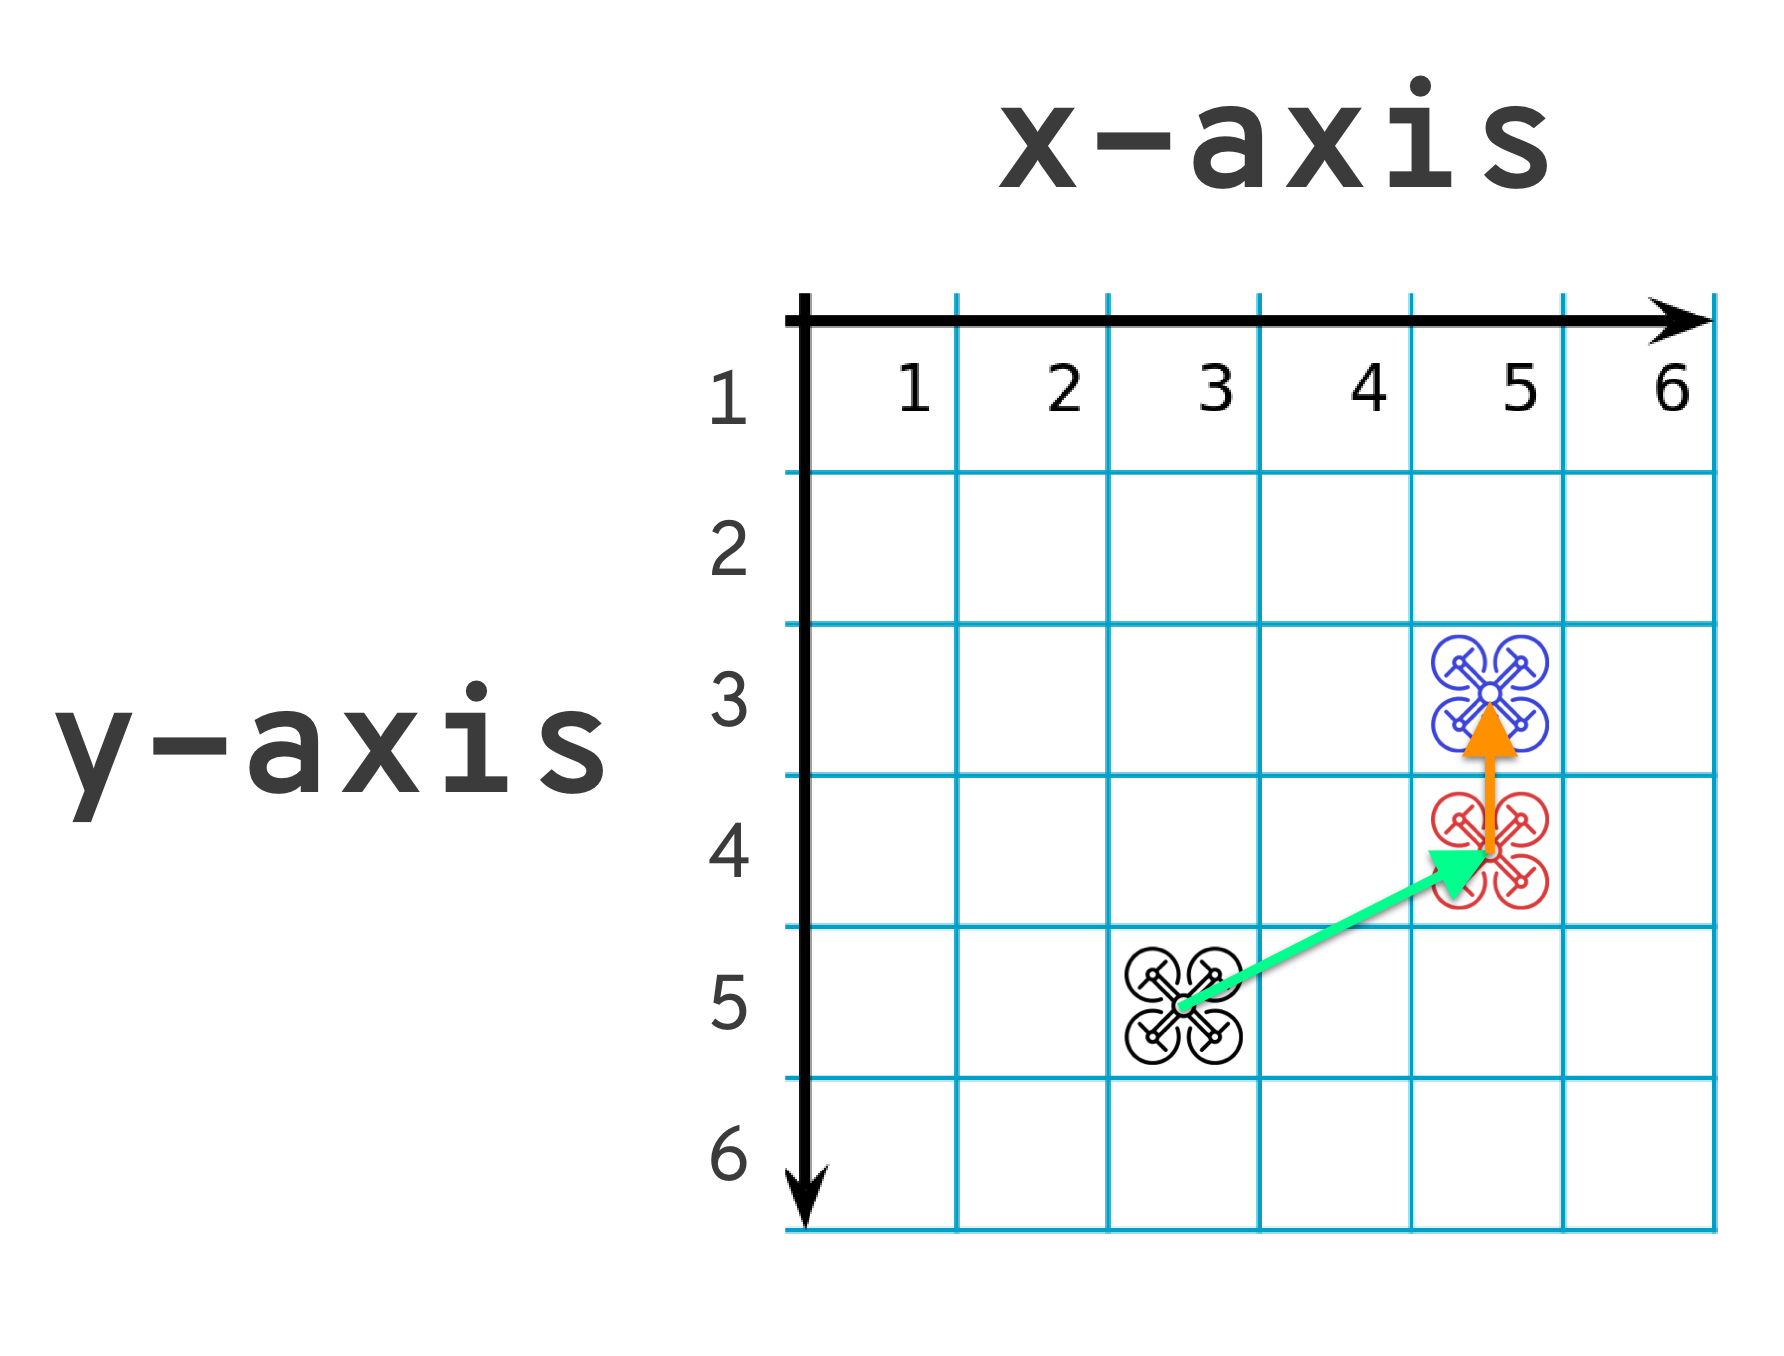

In that image drone moves two frames (steps) from absolute coordinate `(3,5)` first to `(5, 4)` and then to `(5, 3)`.
If we had perfect odometry sensor the readings would be:


| frame | x-odometry | y-odometry |
| ----- | -----------| ---------- |
| 1     | 2          | -1         |
| 2     | 0          | -1         |


Using this data it could be possible to determine absolute position of the drone if we just know the starting position by just integrating over the (relative) odometry sensor readings:

```
final_pos = starting_pos + sum(odometry_readings)
```

There is however little bit noise in those readings so if we just naively integrate over the readings we would not have accurate position as the error caused by noise would accumulate and cause problems.

Fortunately we have made some measurements and got that in those sensor readings we have normal distributed noise `mean=0` and `variance=4.4`

**Coordinates equal to pixels on the map**


## LIDAR

Another fortunate thing is that we also have another sensor on board: [LIDAR](https://en.wikipedia.org/wiki/Lidar)

Using the lidar we can measure distances from the drone to surrounding environment such as walls and other objects.
Lidar measurements are more accurate and there the (normally distributed) noise is just `mean=0` and `variance=0.1`

By utilizing the lidar we can gather distances surrounding the drone from it's current location.

Our drone carries lidar that has angular resolution of **10°**. That means that there will be **36 readings** from every frame

Here is an example of the lidar measurement from the position marked into the map:

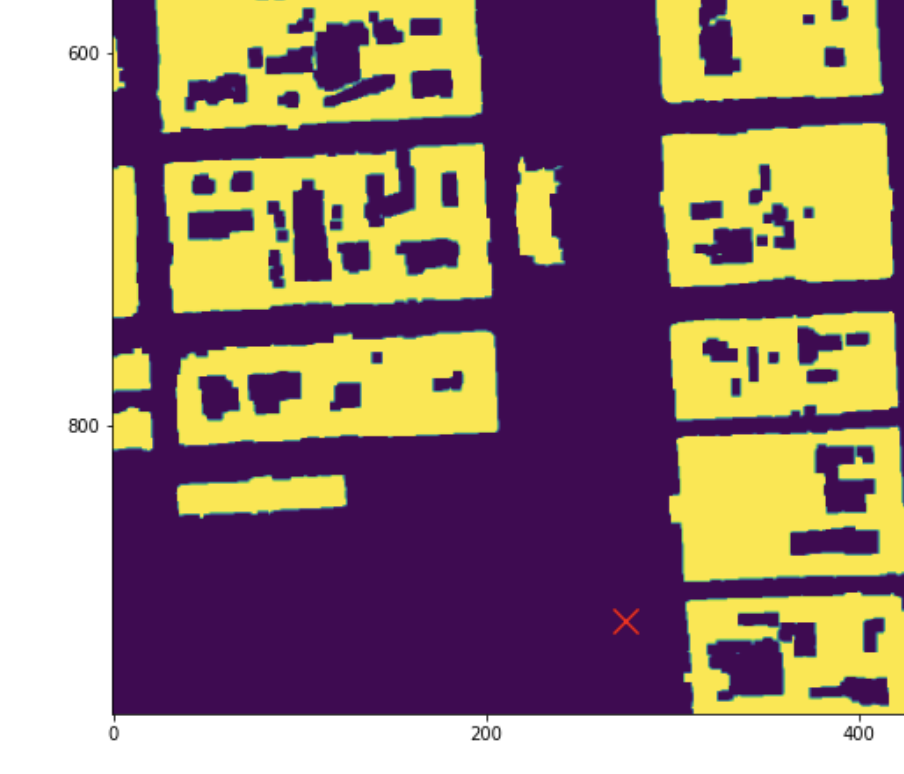

Lidar gets values like this visualized in polar plot:
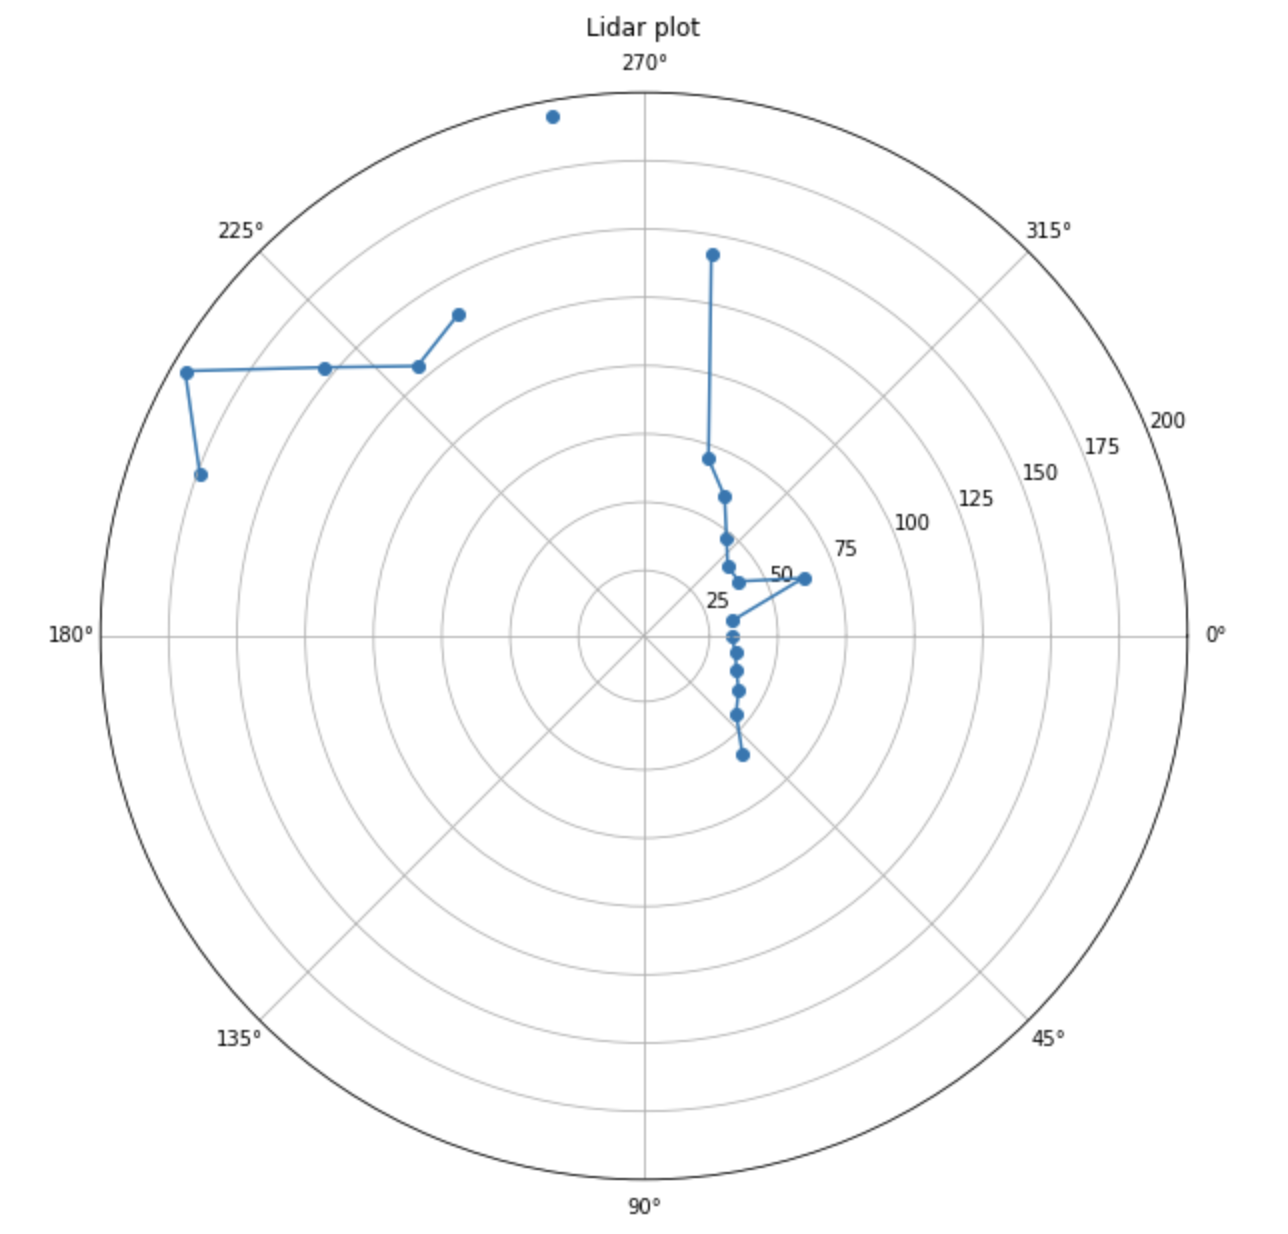
If we would have higher angular resolution lidar it could look like this (just for making it easier to understand how does the lidar data look like)
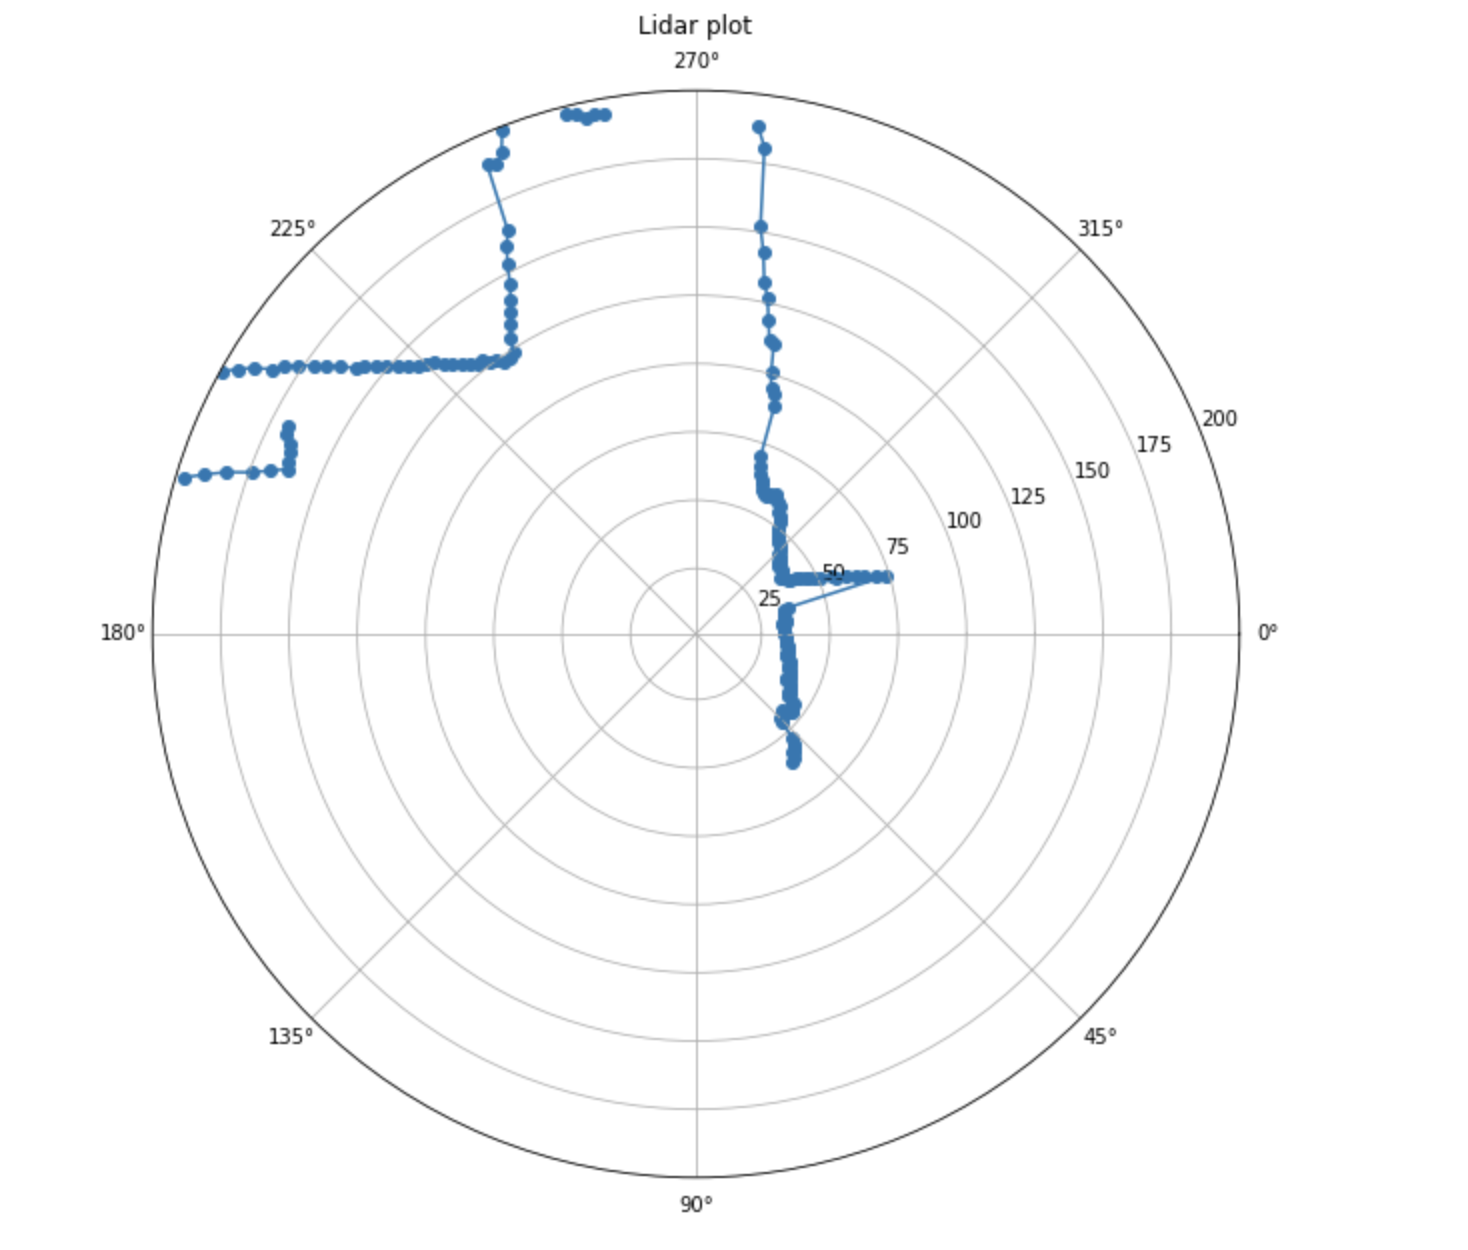

In the measurement log file the lidar data is an list of distances starting with angle 0° and going clockwise in 10° increments.
Each measurement is single item in the list. 0° is pointing to left from the drone, 90° down, 180° right and so on.

There is also limitation with the LIDAR range. Maximum range is **200 pixels** and over that range the measurement will be marked as -1. Also all measurements that are crossing the map boundary will be marked with -1

Lidar distance measurement can be simulated with occupancy map using following naive pseudo code:
```python
# omap = occupation map
# x0,y0 = position of the lidar
# vx,vy = single pixel unit vector to some direction we want to measure the distance
# max_steps = maximum range of the lidar
def measure_distance(omap, x0, y0, vx, vy, max_steps=200):
    y = y0
    x = x0
    # check for boundaries of the map
    wi, he = omap.shape
    for step in range(max_steps):
        y += vy
        x += vx
        if x > wi or x < 0 or y > he or y < 0:
            return -1
        # Check if there is something x, y
        if omap[int(x), int(y)] > 0:
            # Return euclidean distance if there is something
            return sqrt((x0 - x)^2 + (y0 - y)^2)
    return -1
```

### Input data

Input data is newline delimited JSON. Each line is a complete object and represents single frame.
Each object has following fields:

| field       | type             | description |
| ----------- | ---------------- | ----------- |
| odometry_x  | number           | Odometry measurement for x-axis |
| odometry_y  | number           | Odometry measurement for y-axis |
| lidar       | array of numbers | List of distances to surrounding objects |



#### Example
```json
{"odometry_x": 1.996119139727376, "odometry_y": -3.6059551629000577, "lidar": [..]}
{"odometry_x": 1.996119139727376, "odometry_y": -3.6059551629000577, "lidar": [..]}
```

### Output

Solve the problem and produce output in **CSV-format**.
The solution should look like this:

| x   | y   |
| --- | --- |
| 0   | 0   |
| ... | ... |
| 239 | 760 |

(assuming that we left from `(0, 0)` and end up `(239, 760)`)    
each line represents single frame and position (= path drone moved)

### Resources

- [**Occupancy map (in PNG format)**](https://github.com/emblica/drone_assignment/raw/main/map_stadi_bg.png)
- [**Occupancy map (in TXT format)**](https://raw.githubusercontent.com/emblica/drone_assignment/main/map_stadi.txt)
- [**Sensor log (odometry + lidar)**](https://raw.githubusercontent.com/emblica/drone_assignment/main/drone_log.jsonl)

### Final checklist before returning the assignment

- Does the path make sense to you? If it looks random or weird, then it's probably wrong
    
    Path optimzation need to be done.
- Does the path cross buildings or other occupied area? Drone is moving on the street level so it should not collide with anything. If there is just small collisions due sensor noise or your algorithm has not yet converged (when figuring start location) that is fine.

Yes, it crosses the builidings
- Are you proud of your code? Does it represent your skills?

Not really, it represents the way in which i approach and try to solve a problem but due to time constraints and returning my thesis this month i was not able to implement the A* fully. Given more time, i could solve that. 

## Summary

- Find drone path using the sensor log data and known occupancy map
- Odometry sensor has gaussian noise
- Lidar has maximum range of 200 pixels
- Map is accurate
- Drone is moving on the streets
- Lidar is always pointing same direction
- Drone can move left, right, up or down

## Importing Libraries

In [96]:
import json
import math
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
import copy

## Measure distance on omap using the naive pseudocode

In [97]:
def measure_distance(omap, x0, y0, vx, vy, max_steps=200):
    y = y0
    x = x0
    
   
    wi, he = omap.shape
    
    for step in range(max_steps):
        y += vy
        x += vx
        
       
        if x >= wi or x < 0 or y >= he or y < 0:
            return -1
        
        # Check if there is an obstacle at the current position
        if omap[int(y), int(x)] > 0:
            # Calculate and return the Euclidean distance
            distance = math.sqrt((x0 - x)**2 + (y0 - y)**2)
            return distance
    
    return -1


## Reading the omap

In [98]:
def read_2d_array_from_file(file_path):
    
    array_2d = []
    with open(file_path, 'r') as file:
        for line in file:
            row = [int(char) for char in line.strip()]
            array_2d.append(row)

    return array_2d

file_path = 'map_stadi.txt'
array_2d = read_2d_array_from_file(file_path)
array_2d = np.array(array_2d)

array_2d.shape


(955, 1053)

## Path Calculation

In [99]:
# omap = occupation map
# x0,y0 = position of the lidar
# vx,vy = single pixel unit vector to some direction we want to measure the distance
# max_steps = maximum range of the lidar

In [100]:
def calculate_path(sensor_data, omap,drone_pos):

    path = [drone_pos.copy()]
    sim_lidar = []
    all_lidar = []
    
    for frame_data in sensor_data:

       
        x_odom = frame_data['odometry_x']
        y_odom =  - frame_data['odometry_y'] 

        drone_pos += np.array([x_odom,y_odom],dtype=np.float64)
    
        
        path.append(drone_pos.copy())
        

        # Get LIDAR measurements
        
        lidar_measurements = frame_data['lidar']
        temp = copy.deepcopy(drone_pos)
        lidar_sublist = []
        # Calculate LIDAR distances and add them to path
        for angle, distance in enumerate(lidar_measurements):
            if distance == -1:
                continue
            # Convert polar coordinates to Cartesian coordinates
            angle_rad = math.radians(angle * 10)
            vx =  math.cos(angle_rad)
            vy =   - math.sin(angle_rad)  # Negative sign because the y-axis is flipped
            #print(vx,vy)
            
            # Measure distance using LIDAR and update path
            #print(drone_pos)
            measured_distance = measure_distance(omap, drone_pos[0], drone_pos[1], vx, vy)
            if measured_distance != -1:
                new_point = drone_pos + measured_distance * np.array([vx, vy])
                lidar_sublist.append(new_point)
                all_lidar.append(new_point)
            
        sim_lidar.append(lidar_sublist)
        
    return path, sim_lidar,all_lidar

## Kalman Filter for guassian noise

In [101]:
def kalman_filter(noisy_measurements,map_size):
    mod_path = []
    
    # Define measurement noise variance
    measurement_noise_variance = 4.4
    
    # Initialize Kalman filter variables
    state = np.array([0.0, 0.0])  # Initial state estimate
    covariance = np.eye(2) * measurement_noise_variance  # Initial covariance estimate

    for measurement in noisy_measurements:
        #print(measurement['odometry_x'], measurement['odometry_y'])
        measurement_vector = np.array([measurement['odometry_x'], measurement['odometry_y']])
        
        predicted_state = state
        predicted_covariance = covariance
        
        kalman_gain = predicted_covariance.dot(
            np.linalg.inv(predicted_covariance + np.eye(2) * measurement_noise_variance)
        )
        residual = measurement_vector - predicted_state
        state = predicted_state + kalman_gain.dot(residual)
        covariance = (np.eye(2) - kalman_gain).dot(predicted_covariance)

        state[0] = np.clip(state[0], 0, map_size[0] - 1)

        measurement['odometry_x'] = state[0]
        measurement['odometry_y'] = state[1]
        
        mod_path.append(state)
    
    return noisy_measurements




In [102]:

omap = array_2d
print(omap.shape)



sensor_data = []
with open('drone_log.jsonl', 'r') as f:
    for line in f:
        sensor_data.append(json.loads(line))

drone_pos = np.array([0.0, 0.0], dtype=np.float64)



mod_path = kalman_filter(sensor_data,omap.shape)
output,obs,lid = calculate_path(mod_path,omap,drone_pos)
        

(955, 1053)


In [103]:
import math
import heapq

# Euclidean distance heuristic for A*

def heuristic(node, goal):
    return np.abs(node - goal).sum()

def get_neighbors(node, obstacle_list, omap):
    neighbors = []
    possible_moves = [(1, 0), (0, 1), (-1, 0), (0, -1)]

    for move in possible_moves:
        new_node = node + move

        if (0 <= new_node[0] < omap.shape[0]) and (0 <= new_node[1] < omap.shape[1]) and (omap[int(new_node[0]),int(new_node[1])] != 1):
            if not any(np.array_equal(new_node, obstacle) for obstacle in obstacle_list):
                neighbors.append(new_node)


    return neighbors

def a_star(start, goal, obstacle_list, omap):
    open_list = []
    closed_set = set()
    start = tuple(map(int, start))
    g_score = {start: 0}  

    heapq.heappush(open_list, (0, start))
    came_from = {}

    while open_list:
        current_cost, current_node = heapq.heappop(open_list)
        
        if np.array_equal(current_node, goal):
            path = [current_node]
            while current_node in came_from:
                current_node = came_from[current_node]
                path.insert(0, current_node)
            return path

        closed_set.add(tuple(current_node))

        neighbors = get_neighbors(current_node, obstacle_list, omap)
        for neighbor in neighbors:
            if tuple(neighbor) in closed_set:
                continue

            tentative_g = g_score[current_node] + 1

            if neighbor not in open_list or tentative_g < g_score[neighbor]:
                came_from[neighbor] = current_node
                g_score[neighbor] = tentative_g
                f_score = tentative_g + heuristic(neighbor, goal)
                heapq.heappush(open_list, (f_score, neighbor))

    return None


In [104]:


# Write the final path to CSV
with open('drone_path.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['x', 'y'])
    for point in output:
        csv_writer.writerow(point)

print("Path successfully calculated and saved to 'drone_path.csv'")


Path successfully calculated and saved to 'drone_path.csv'


## Orignal path based on odometry

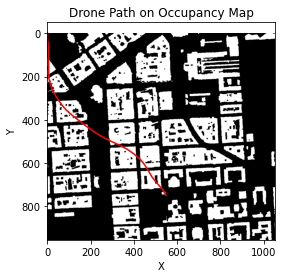

In [94]:
pixel_size = 1
plt.imshow(omap, cmap='gray')  # Display the occupancy map
plt.plot([p[0] / pixel_size for p in output], [p[1] / pixel_size for p in output], color='red')  # Plot the path
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Drone Path on Occupancy Map')
plt.show()

## Lidar information updated but no best path searching is performed

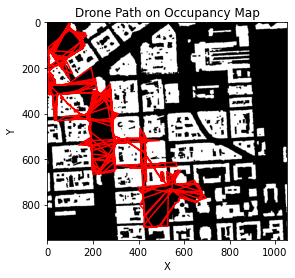

In [95]:
pixel_size = 1
plt.imshow(omap, cmap='gray')  # Display the occupancy map
plt.plot([p[0] / pixel_size for p in lid], [p[1] / pixel_size for p in lid], color='red')  # Plot the path
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Drone Path on Occupancy Map')
plt.show()